In [ ]:
#@title ScoreNet

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False, output_padding=0)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)

    # print("h3: ", end='')
    # print(h3.shape)

    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path

    # print("h4: ", end='')
    # print(h4.shape)

    h = self.tconv4(h4)

    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)

    # print("h: ", end='')
    # print(h.shape)

    # print("END")
    # print(h3.shape)

    h = self.tconv3(torch.cat([h, h3], dim=1))



    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [ ]:
#@title Set up the SDE

device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}


# default sde setup

def default_marginal_prob_std(t, sigma):  
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def default_diffusion_coeff(t, sigma):
  return torch.tensor(sigma**t, device=device)
  
sigma_default =  5
default_marginal_prob_std_fn = functools.partial(default_marginal_prob_std, sigma=sigma_default)
default_diffusion_coeff_fn = functools.partial(default_diffusion_coeff, sigma=sigma_default)


# variance exploding setup

def ve_marginal_prob_std(t,sigma_min,sigma_max):
    std = sigma_min * (sigma_max / sigma_min) ** t
    return std

def ve_diffusion_coeff(t,sigma_min,sigma_max): 
    sigma = sigma_min * (sigma_max / sigma_min) ** t
    diffusion = sigma * torch.sqrt(torch.tensor(2 * (np.log(sigma_max) - np.log(sigma_min)),
                                                device=t.device))
    return diffusion

sigma_min_ve = 0.01
sigma_max_ve = 5
ve_marginal_prob_std_fn = functools.partial(ve_marginal_prob_std, sigma_min=sigma_min_ve, sigma_max=sigma_max_ve)
ve_diffusion_coeff_fn = functools.partial(ve_diffusion_coeff, sigma_min=sigma_min_ve, sigma_max=sigma_max_ve)


# sub variance preserving setup

def subvp_marginal_prob_std(t, beta_min, beta_max):
    log_mean_coeff = -0.25 * t ** 2 * (beta_max - beta_min) - 0.5 * t * beta_min
    std = 1 - torch.exp(2. * log_mean_coeff)
    return std

def subvp_diffusion_coeff(t, beta_min, beta_max):
    beta_t = beta_min + t * (beta_max - beta_min)
    discount = 1. - torch.exp(-2 * beta_min * t - (beta_max - beta_min) * t ** 2)
    diffusion = torch.sqrt(beta_t * discount)
    return diffusion

def subvp_drift_coeff(t, x, beta_min, beta_max):
    beta_t = beta_min + t * (beta_max - beta_min)
    if beta_t.dim() == 0:
        drift = -0.5 * beta_t * x
    else:
        drift = -0.5 * beta_t[:, None, None, None] * x
    return drift

beta_min_subvp = 0.01
beta_max_subvp = 5
subvp_marginal_prob_std_fn = functools.partial(subvp_marginal_prob_std, beta_min=beta_min_subvp, beta_max=beta_max_subvp)
subvp_diffusion_coeff_fn = functools.partial(subvp_diffusion_coeff, beta_min=beta_min_subvp, beta_max=beta_max_subvp)
subvp_drift_coeff_fn = functools.partial(subvp_drift_coeff, beta_min=beta_min_subvp, beta_max=beta_max_subvp)


# variance preserving setup

def vp_marginal_prob_std(t, beta_min, beta_max):
    log_mean_coeff = -0.25 * t ** 2 * (beta_max - beta_min) - 0.5 * t * beta_min
    std = torch.sqrt(1. - torch.exp(2. * log_mean_coeff))
    return std

def vp_diffusion_coeff(t, beta_min, beta_max):
    beta_t = beta_min + t * (beta_max - beta_min)
    diffusion = torch.sqrt(beta_t)
    return diffusion

def vp_drift_coeff(t, x, beta_min, beta_max):
    beta_t = beta_min + t * (beta_max - beta_min)
    if beta_t.dim() == 0:
        drift = -0.5 * beta_t * x
    else:
        drift = -0.5 * beta_t[:, None, None, None] * x
    return drift

beta_min_vp = .01
beta_max_vp = 5
vp_marginal_prob_std_fn = functools.partial(vp_marginal_prob_std, beta_min=beta_min_vp, beta_max=beta_max_vp)
vp_drift_coeff_fn = functools.partial(vp_drift_coeff, beta_min=beta_min_vp, beta_max=beta_max_vp)
vp_diffusion_coeff_fn = functools.partial(vp_diffusion_coeff, beta_min=beta_min_vp, beta_max=beta_max_vp)



# so that we can conveniently change the sde for the rest of the code

sde = 'VE' #@param ['default', 'VE', 'VP', 'subVP'] {'type': 'string'}

marginal = None
diffusion_coeff = None
drift_coeff = None
model_name = None

if sde == 'VE':
  marginal = ve_marginal_prob_std_fn
  diffusion_coeff = ve_diffusion_coeff_fn
  model_name = 'ckpt_ve.pth'
elif sde == 'VP':
  marginal = vp_marginal_prob_std_fn
  diffusion_coeff = vp_diffusion_coeff_fn
  drift_coeff = vp_drift_coeff_fn
  model_name = 'ckpt_vp.pth'
elif sde == 'subVP':
  marginal = subvp_marginal_prob_std_fn
  diffusion_coeff = subvp_diffusion_coeff_fn
  drift_coeff = subvp_drift_coeff_fn
  model_name = 'ckpt_subvp.pth'
else:
  marginal = default_marginal_prob_std_fn
  diffusion_coeff = default_diffusion_coeff_fn
  model_name = 'ckpt_default.pth'


In [ ]:
#@title Define the loss function (double click to expand or collapse)

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [ ]:
# # perturbation series

# import torch
# import functools
# from torch.optim import Adam
# from torch.utils.data import DataLoader
# import torchvision.transforms as transforms
# from torchvision.datasets import MNIST
# from torchvision.datasets import StanfordCars
# import tqdm
# import numpy as np
# from PIL import Image
# import matplotlib.pyplot as plt

# def ve_marginal_prob_std(t,sigma_min,sigma_max):
#     std = sigma_min * (sigma_max / sigma_min) ** t
#     return std

# def ve_diffusion_coeff(t,sigma_min,sigma_max): 
#     sigma = sigma_min * (sigma_max / sigma_min) ** t
#     diffusion = sigma * torch.sqrt(torch.tensor(2 * (np.log(sigma_max) - np.log(sigma_min)),
#                                                 device=t.device))
#     return diffusion

# # sigma_min = 0.01
# # sigma_max = 50
# sigma_min = 5
# sigma_max = 100
# ve_marginal_prob_std_fn = functools.partial(ve_marginal_prob_std, sigma_min=sigma_min, sigma_max=sigma_max)

# # marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma)

# eps = 1e-5

# dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
# data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

# batch, y = next(iter(data_loader))
# x = batch[0]

# fig, ax = plt.subplots(2, 4, figsize=(14,14), tight_layout=True)
# ax = ax.flat
# img = ax[0].imshow(x.squeeze())

# for i in range(0, 7):
#   random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
#   z = torch.randn_like(x)
#   std = ve_marginal_prob_std_fn(random_t)

#   perturbed_x = x + z * std[:, None, None, None]
#   x = perturbed_x

#   img = ax[i+1].imshow(x.squeeze())


In [ ]:
#@title Training (double click to expand or collapse)

import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.datasets import StanfordCars
import tqdm


score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal))
score_model = score_model.to(device)

n_epochs =   50#@param {'type':'integer'}
## size of a mini-batch
batch_size =  32 #@param {'type':'integer'}
## learning rate
lr=1e-4 #@param {'type':'number'}

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)    
    loss = loss_fn(score_model, x, marginal)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), model_name)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
#@title Define the Euler-Maruyama sampler (double click to expand or collapse)

import matplotlib.pyplot as plt

# progressive perturbation fn
def perturb(x, t, marginal_prob_std):
    ''' Perturb a raw image x_0 with some diffusion noise at level t
        args:
            x_0: np.array, 2D image
            t: int, level of perturbation (from 0 to 1)
            sigma: influences the magnitude of noise
        return:
            x_t: np.array, perturbed image
    '''
    std = marginal_prob_std(t)
    z = torch.randn_like(x)
    return x + z * std.unsqueeze(0)[:, None]


## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff,
                           drift_coeff,
                           batch_size=64, 
                           num_steps=num_steps, 
                           device='cuda', 
                           eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns:
    Samples.    
  """

  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      if drift_coeff == None:
          mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      else:
          f = drift_coeff(batch_time_step, x)
          mean_x = x + ( -1 * f + ((g**2)[:, None, None, None] * score_model(x, batch_time_step)) ) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
  # Do not include any noise in the last sampling step.
  return mean_x


def Euler_Maruyama_inverse_sampler(y0, score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           drift_coeff,
                           batch_size=64, 
                           num_steps=num_steps, 
                           device='cuda', 
                           eps=1e-3,
                           lamb=0.01):
  
  # sample x from pt
  t = torch.ones(1, device=device) # scalar
  xt = torch.randn(28, 28, device=device) * marginal_prob_std(t)[:, None] # 28x28 matrix

  # set up time steps
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  lamb_schedule = lamb / num_steps
  
  # y vector
  y = [perturb(y0, time_step, marginal_prob_std) for time_step in time_steps[:-1]]
  y.insert(0, y0)

  x = xt
  idx = 1
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):
      # reverse sde to get initial xi
      g = diffusion_coeff(time_step) 
      g2 = (g**2).unsqueeze(0)[:, None]

      repeat_score = score_model(x.unsqueeze(0).repeat(32,1,1,1).float(), torch.full((32,) , time_step, device=x.device))
      score = repeat_score[0].squeeze()

      mean_x = None
      if drift_coeff == None:
        mean_x = x + g2 * score * step_size
      else:
        f = drift_coeff(time_step, x).unsqueeze()[:, None]
        mean_x = x + (-1 * f + (g2 * score)) * step_size

      x = mean_x + torch.sqrt(step_size) * g.unsqueeze(0)[:, None] * torch.randn_like(x)

      # then constrain x by y
      yi = y[-idx]
      idx += 1

      x = lamb * yi + (1 - lamb) * x
      lamb = lamb - lamb_schedule

  return x, yi


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

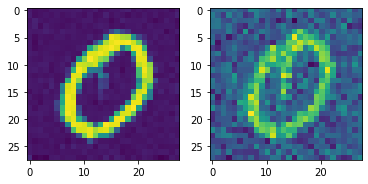

In [ ]:
#@title Denoising
import torch
from torchvision.utils import make_grid
import tqdm
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal))
score_model = score_model.to(device)

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load(model_name, map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 32 #@param {'type':'integer'}
sampler = Euler_Maruyama_inverse_sampler #@param ['Euler_Maruyama_sampler', 'Euler_Maruyama_inverse_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

# dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
# data_loader = DataLoader(dataset, batch_size=sample_batch_size, shuffle=True, num_workers=4)
images, _ = next(iter(data_loader))
y0 = images[0].to(device)
y0 = y0 + 0.2 * torch.randn_like(y0)

## Generate samples using the specified sampler.
samples, yi = sampler(y0, score_model, 
                  marginal,
                  diffusion_coeff,
                  drift_coeff, 
                  sample_batch_size, 
                  device=device)

# Sample visualization.
plt.figure()
f, axarr = plt.subplots(1,2) 

axarr[1].imshow(yi.squeeze().to('cpu'))
axarr[0].imshow(samples.squeeze().to('cpu'))

  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

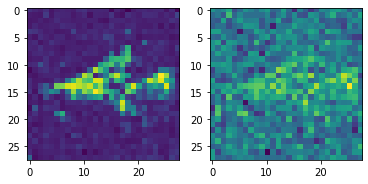

In [ ]:
#@title Transfer Denoising

from torchvision.datasets import FashionMNIST

sample_batch_size = 32 #@param {'type':'integer'}
sampler = Euler_Maruyama_inverse_sampler #@param ['Euler_Maruyama_sampler', 'Euler_Maruyama_inverse_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

f_dataset = FashionMNIST('.', train=True, transform=transforms.ToTensor(), download=True)
f_data_loader = DataLoader(f_dataset, batch_size=sample_batch_size, shuffle=True, num_workers=4)

f_images, _ = next(iter(f_data_loader))
f_y0 = f_images[0].to(device)
f_y0 = f_y0 + 0.4 * torch.randn_like(f_y0)

# plt.imshow(f_y0.squeeze().to('cpu'))

## Generate samples using the specified sampler.
f_samples, f_yi = sampler(f_y0, score_model, 
                  marginal,
                  diffusion_coeff,
                  drift_coeff, 
                  sample_batch_size, 
                  device=device,
                  lamb=0.02)

# Sample visualization.
plt.figure()
f, axarr = plt.subplots(1,2) 

axarr[1].imshow(f_yi.squeeze().to('cpu'))
axarr[0].imshow(f_samples.squeeze().to('cpu'))

In [ ]:
#@title Define the Predictor-Corrector sampler (double click to expand or collapse)

signal_to_noise_ratio = 0.16 #@param {'type':'number'}

## The number of sampling steps.
num_steps =  500#@param {'type':'integer'}
def pc_sampler(score_model, 
               marginal_prob_std,
               diffusion_coeff,
               drift_coeff,
               lamb=0.01,
               batch_size=64, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,                
               device='cuda',
               eps=1e-3):
  """Generate samples from score-based models with Predictor-Corrector method.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient 
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.    
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns: 
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]

  lamb_schedule = lamb / step_size

  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # Corrector step (Langevin MCMC)
      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)

      x_mean = None
      if drift_coeff == None:
          x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      else:
          f = drift_coeff(x, batch_time_step)
          x_mean = x + ( -1 * f + ((g**2)[:, None, None, None] * score_model(x, batch_time_step)) ) * step_size
  
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)      
    
    # The last step does not include any noise
    return x_mean


In [ ]:
#@title Define the ODE sampler (double click to expand or collapse)

from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 #@param {'type': 'number'}
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                drift_coeff=None,
                batch_size=64, 
                atol=error_tolerance, 
                rtol=error_tolerance, 
                device='cuda', 
                z=None,
                eps=1e-3):
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z
    
  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
    with torch.no_grad():    
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def ode_func(t, x):        
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t    
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    
    if drift_coeff == None:
      return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)
    else:
      f = drift_coeff(torch.tensor(t), x).cpu().numpy()
      return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps) + f
  
  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')  
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x


  0%|          | 0/500 [00:00<?, ?it/s]

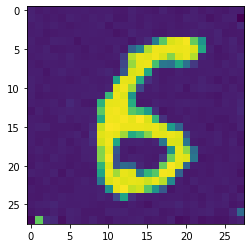

In [ ]:
#@title Sampling (USE FOR PLAIN SAMPLING)
import torch
from torchvision.utils import make_grid
import tqdm

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal))
score_model = score_model.to(device)

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load(model_name, map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model, 
                  marginal,
                  diffusion_coeff,
                  drift_coeff, 
                  sample_batch_size, 
                  device=device)

## Sample visualization.
# samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
# sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# plt.figure(figsize=(6,6))
# plt.axis('off')
# # plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
# plt.show()
plt.imshow(samples[0].squeeze().to('cpu'))

In [ ]:
#@title Fat Matrix Inverse Problem

import numpy as np
import torch
from torchvision.utils import make_grid
import tqdm
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


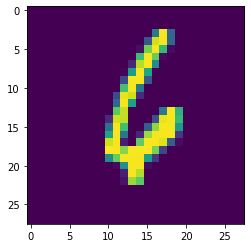

In [ ]:
# getting an input image

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
images, _ = next(iter(data_loader))

x = images[0]

plt.imshow(x.squeeze())

x = x.to('cuda')

In [ ]:
# Fat matrix downsampling that takes the first 14 rows

def rinv(B):
  # invB = B^T(BB^T)^-1
  return torch.matmul(torch.t(B), torch.inverse(torch.matmul(B, torch.t(B))))


# Defining P to downsample
P = torch.eye(28**2)
keep = [i for i in range(28**2)]
random.shuffle(keep)
keep = torch.sort(torch.tensor(keep[0:300]))[0]
P = torch.index_select(P, 0, keep).to('cuda')


# Lamb is a subsampling mask
Lamb = torch.zeros((28**2, 28**2)).to('cuda')
for i in range(keep.size()[0]):
  Lamb[keep[i], keep[i]] = 1

# make well conditioned gaussian T
T = torch.normal(0, 1, size=(28**2,28**2)).to('cuda')
U, S, V = torch.linalg.svd(T)
T = torch.matmul(U, torch.t(V))

# get y from x
A = torch.matmul(torch.matmul(P, Lamb), T)
y = torch.matmul(A, x.reshape((-1, 1)))


# inpainting visualization

# yvis = np.unravel_index(np.arange(600), (28,28))
# new_image = np.zeros((28, 28))
# new_image[yvis] = x.squeeze()[yvis]

# plt.imshow(new_image)

In [ ]:
len(keep)

300

In [ ]:
# progressive perturbation fn
def perturb(x, t, marginal_prob_std):
    std = marginal_prob_std(t)
    z = torch.randn_like(x)
    return x + z * std.unsqueeze(0)[:, None]


def Euler_Maruyama_general_inverse_sampler(y0,
                                           P,
                                           Lamb,
                                           T,
                                           score_model, 
                                           marginal_prob_std,
                                           diffusion_coeff,
                                           drift_coeff,
                                           batch_size=64,
                                           num_steps=500,
                                           device='cuda',
                                           eps=1e-3,
                                           lamb=0.05):
  
  # sample x from pt
  t = torch.ones(1, device=device) # scalar
  xt = torch.randn(28, 28, device=device) * marginal_prob_std(t)[:, None] # 28x28 matrix

  # set up time steps
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  lamb_schedule = lamb / num_steps
  
  # y vector
  y = [perturb(y0, time_step, marginal_prob_std) for time_step in time_steps]

  x = xt
  idx = 0
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):
      # reverse sde to get initial xi
      g = diffusion_coeff(time_step) 
      g2 = (g**2).unsqueeze(0)[:, None]

      repeat_score = score_model(x.unsqueeze(0).repeat(32,1,1,1).float(), torch.full((32,) , time_step, device=x.device))
      score = repeat_score[0].squeeze()

      mean_x = None
      if drift_coeff == None:
        mean_x = x + g2 * score * step_size
      else:
        f = drift_coeff(time_step, x).unsqueeze()[:, None]
        mean_x = x + (-1 * f + (g2 * score)) * step_size

      x = mean_x + torch.sqrt(step_size) * g.unsqueeze(0)[:, None] * torch.randn_like(x)

      # then constrain x by y

      # set up y
      yi = y[idx].squeeze()
      idx += 1

      # flatten x and y into column vectors
      xflat = x.reshape((-1))

      # calculate closed form solution
      term1 = lamb * torch.matmul(torch.matmul(Lamb, rinv(P)), yi)
      term2 = (1 - lamb) * torch.matmul(torch.matmul(Lamb, T), xflat.float())
      term3 = torch.matmul((torch.eye(28**2).to(device) - Lamb), torch.matmul(T, xflat.float()))
      xflat = torch.matmul(torch.inverse(T), term1 + term2 + term3)

      # restore x and decrement lamb
      x = xflat.reshape((28, 28))
  
      if idx == num_steps / 1.1:
        lamb = 0.05

  return x, yi

  0%|          | 0/500 [00:00<?, ?it/s]

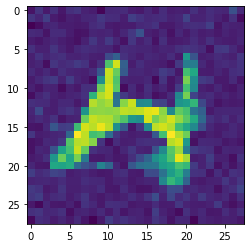

In [ ]:
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal))
score_model = score_model.to(device)

# Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load(model_name, map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 32 #@param {'type':'integer'}
sampler = Euler_Maruyama_general_inverse_sampler

# Generate samples using the specified sampler.
xi, yi = sampler(y.to(device),
                 P,
                 Lamb,
                 T,
                 score_model,
                 marginal,
                 diffusion_coeff,
                 drift_coeff,
                 sample_batch_size,
                 device=device
                 )

# Sample visualization.
plt.imshow(xi.reshape((28,28)).squeeze().to('cpu'))

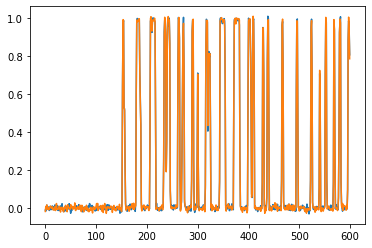

In [ ]:
# sanity check y perturbation series

time_steps = torch.linspace(1., 1e-3, 500, device=device)
yarr = [perturb(y, time_step, marginal) for time_step in time_steps]

# plt.plot(yarr[0].cpu())
# plt.plot(yarr[100].cpu())

plt.plot(yi.cpu())
plt.plot(yarr[-1].cpu())

In [ ]:
#@title Brain Dataset Class

from torch.utils.data import Dataset
import os
import h5py

class BrainImages(Dataset):
  def __init__(self, path):
    self.path = path
    self.files = os.listdir(path)
    self.files = [f for f in self.files if f[-4:] == '.mat' ]

  def __len__(self):
    return len(self.files)
  
  def __getitem__(self, idx):
    filename = self.files[idx]
    f = h5py.File(self.path + '/' + filename)
    img = np.array(f['Sinogram'][:])

    return torch.from_numpy(img), 0


dataset = BrainImages('brain_images')
dataloader = DataLoader(dataset, batch_size=3, shuffle=False, num_workers=0)

for x, y in dataloader:
  print(x.shape)


torch.Size([3, 512, 2000])


In [ ]:
#@title Define the likelihood function (double click to expand or collapse)

def prior_likelihood(z, sigma):
  """The likelihood of a Gaussian distribution with mean zero and 
      standard deviation sigma."""
  shape = z.shape
  N = np.prod(shape[1:])
  return -N / 2. * torch.log(2*np.pi*sigma**2) - torch.sum(z**2, dim=(1,2,3)) / (2 * sigma**2)

def ode_likelihood(x, 
                   score_model,
                   marginal_prob_std, 
                   diffusion_coeff,
                   batch_size=64, 
                   device='cuda',
                   eps=1e-5):
  """Compute the likelihood with probability flow ODE.
  
  Args:
    x: Input data.
    score_model: A PyTorch model representing the score-based model.
    marginal_prob_std: A function that gives the standard deviation of the 
      perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the 
      forward SDE.
    batch_size: The batch size. Equals to the leading dimension of `x`.
    device: 'cuda' for evaluation on GPUs, and 'cpu' for evaluation on CPUs.
    eps: A `float` number. The smallest time step for numerical stability.

  Returns:
    z: The latent code for `x`.
    bpd: The log-likelihoods in bits/dim.
  """

  # Draw the random Gaussian sample for Skilling-Hutchinson's estimator.
  epsilon = torch.randn_like(x)
      
  def divergence_eval(sample, time_steps, epsilon):      
    """Compute the divergence of the score-based model with Skilling-Hutchinson."""
    with torch.enable_grad():
      sample.requires_grad_(True)
      score_e = torch.sum(score_model(sample, time_steps) * epsilon)
      grad_score_e = torch.autograd.grad(score_e, sample)[0]
    return torch.sum(grad_score_e * epsilon, dim=(1, 2, 3))    
  
  shape = x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper for evaluating the score-based model for the black-box ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
    with torch.no_grad():    
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def divergence_eval_wrapper(sample, time_steps):
    """A wrapper for evaluating the divergence of score for the black-box ODE solver."""
    with torch.no_grad():
      # Obtain x(t) by solving the probability flow ODE.
      sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
      time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
      # Compute likelihood.
      div = divergence_eval(sample, time_steps, epsilon)
      return div.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def ode_func(t, x):
    """The ODE function for the black-box solver."""
    time_steps = np.ones((shape[0],)) * t    
    sample = x[:-shape[0]]
    logp = x[-shape[0]:]
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    sample_grad = -0.5 * g**2 * score_eval_wrapper(sample, time_steps)
    logp_grad = -0.5 * g**2 * divergence_eval_wrapper(sample, time_steps)
    return np.concatenate([sample_grad, logp_grad], axis=0)

  init = np.concatenate([x.cpu().numpy().reshape((-1,)), np.zeros((shape[0],))], axis=0)
  # Black-box ODE solver
  res = integrate.solve_ivp(ode_func, (eps, 1.), init, rtol=1e-5, atol=1e-5, method='RK45')  
  zp = torch.tensor(res.y[:, -1], device=device)
  z = zp[:-shape[0]].reshape(shape)
  delta_logp = zp[-shape[0]:].reshape(shape[0])
  sigma_max = marginal_prob_std(1.)
  prior_logp = prior_likelihood(z, sigma_max)
  bpd = -(prior_logp + delta_logp) / np.log(2)
  N = np.prod(shape[1:])
  bpd = bpd / N + 8.
  return z, bpd

In [ ]:
#@title Compute likelihood on the dataset (double click to expand or collapse)

batch_size = 32 #@param {'type':'integer'}

dataset = MNIST('.', train=False, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

all_bpds = 0.
all_items = 0
try:
  tqdm_data = tqdm.notebook.tqdm(data_loader)
  for x, _ in tqdm_data:
    x = x.to(device)
    # uniform dequantization
    x = (x * 255. + torch.rand_like(x)) / 256.    
    _, bpd = ode_likelihood(x, score_model, marginal_prob_std_fn,
                            diffusion_coeff_fn,
                            x.shape[0], device=device, eps=1e-5)
    all_bpds += bpd.sum()
    all_items += bpd.shape[0]
    tqdm_data.set_description("Average bits/dim: {:5f}".format(all_bpds / all_items))

except KeyboardInterrupt:
  # Remove the error message when interuptted by keyboard or GUI.
  pass


  0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
